In [1]:
import os

# home_dir = '/content/gdrive/My Drive/AChina' 
# home_dir = '/hy-tmp'
# os.chdir(home_dir)
# pwd

!pip install tqdm 
!pip install fire

from glob import glob
from tqdm import tqdm

import numpy as np
import pandas as pd

import os
import warnings
import sys

import fire

# warnings.filterwarnings("ignore")  # avoid printing out absolute paths

# os.chdir("../../..")

!pip install scipy
!pip install torch 
!pip install pytorch_lightning==1.9.0 pytorch_forecasting

import copy
from pathlib import Path
import warnings

import time

import numpy as np
import pandas as pd
import pytorch_lightning as pl
from pytorch_lightning.callbacks import EarlyStopping, LearningRateMonitor
from pytorch_lightning.loggers import TensorBoardLogger
import torch

from typing import Any, Callable, Dict, List, Optional, Tuple, Union
from pytorch_forecasting import Baseline, TemporalFusionTransformer, TimeSeriesDataSet
from pytorch_forecasting.data import GroupNormalizer
from pytorch_forecasting.metrics import MAPE, SMAPE, PoissonLoss, QuantileLoss, RMSE, MAE
from matplotlib import pyplot as plt
from pytorch_lightning.utilities.model_summary import summarize
from pytorch_forecasting import TemporalFusionTransformer
from pytorch_lightning import Trainer
from pytorch_lightning.loggers import TensorBoardLogger
from pytorch_lightning.callbacks import ModelCheckpoint, StochasticWeightAveraging
from matplotlib import pyplot as plt

from multiprocessing import Pool, freeze_support

Looking in indexes: https://mirrors.aliyun.com/pypi/simple
You should consider upgrading via the '/usr/bin/python3.8 -m pip install --upgrade pip' command.
Looking in indexes: https://mirrors.aliyun.com/pypi/simple
You should consider upgrading via the '/usr/bin/python3.8 -m pip install --upgrade pip' command.
Looking in indexes: https://mirrors.aliyun.com/pypi/simple
You should consider upgrading via the '/usr/bin/python3.8 -m pip install --upgrade pip' command.
Looking in indexes: https://mirrors.aliyun.com/pypi/simple
You should consider upgrading via the '/usr/bin/python3.8 -m pip install --upgrade pip' command.
Looking in indexes: https://mirrors.aliyun.com/pypi/simple
You should consider upgrading via the '/usr/bin/python3.8 -m pip install --upgrade pip' command.


/usr/local/lib/python3.8/dist-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [2]:
home_dir = '/hy-tmp'        
os.chdir(home_dir)

!pwd

# !ls

pl.seed_everything(1234, workers=True)

# from google.colab import drive
# drive.mount('/content/gdrive/')

# !ls

# home_dir = '/content/gdrive/My Drive/AChina'        
# os.chdir(home_dir)
# !pwd

/hy-tmp


Global seed set to 1234


1234

In [3]:
# data = np.load('A0mod_A0cr[rice]-yr[2005_2010_2017]-en[A0_RMSE_cyclic]-bs[128]-lr[0.01]_predict.npz')
# data = np.load('A0mod_A0cr[rice]-yr[2005_2010_2017]-en[A0_RMSE_cyclic]-bs[128]-lr[0.01]_test.npz')
# filename = f'EXP_[A0AF_RMSE]-Cr[rice]-KF[2005_2010_2017]-BS[128]]'
# filename = f'EXP_[A0AF_RMSE]-Cr[rice]-KF[2005_2010_2017]-BS[128]]'
# filename = f'EXP_[A0AM_TRAIN]-Cr[rice]-KF[2005_2010_2017]-BS[128]]'
filename = f'EXP_[ZA0AM_CONV]-Cr[rice]-KF[2005_2010_2017]-BS[128]]'

data = np.load(f'{filename}_predict.npz')
# data = np.load('A0Bmod_A0Bcr[rice]-yr[2005_2010_2017]-en[A0B]-bs[128]-lr[0.01]_test_.npz')
checkpoint_file = f'{filename}'

for ks in data.keys():
    print(ks)


actuals
predictions
prediction
encoder_target
decoder_target


Global seed set to 123456


A0AM_vis rice
predicted_years: ['2005', '2010', '2017'] max_epochs: 100 batch_size: 16 learning_rate 0.0325 loss_func_metric: RMSE seed: 123456 lr_milestones_list: [20, 50, 600, 800]
loading data/ALIM128F64DATASET_rice.csv Tue Apr 11 20:52:45 2023
data/ALIM128F64DATASET_rice.csv loaded Tue Apr 11 20:52:55 2023
432 540
yild: (432, 1)
norm_yield: (432, 1)
norm_yield[ii]: 8.617911948580124
norm_yield[ii]: 0.7648090740557005
norm_yield[ii]: -1.3191347327037235
norm_yield[ii]: -2.461432967947896
norm_yield[ii]: -0.3032318761864301
norm_yield[ii]: -0.06624054107353192
norm_yield[ii]: -0.9644377011514187
norm_yield[ii]: -0.4533263884245995
norm_yield[ii]: 0.5199180277723715
norm_yield[ii]: 0.41801175367382487
norm_yield[ii]: -1.7006907822354906
norm_yield[ii]: -1.2306579675949079
norm_yield[ii]: -1.03079527498303
norm_yield[ii]: -0.14760756612896034
norm_yield[ii]: -1.838935727718015
norm_yield[ii]: 0.9694115933698358
norm_yield[ii]: 0.4274914070783406
norm_yield[ii]: -1.2156485163710908
norm

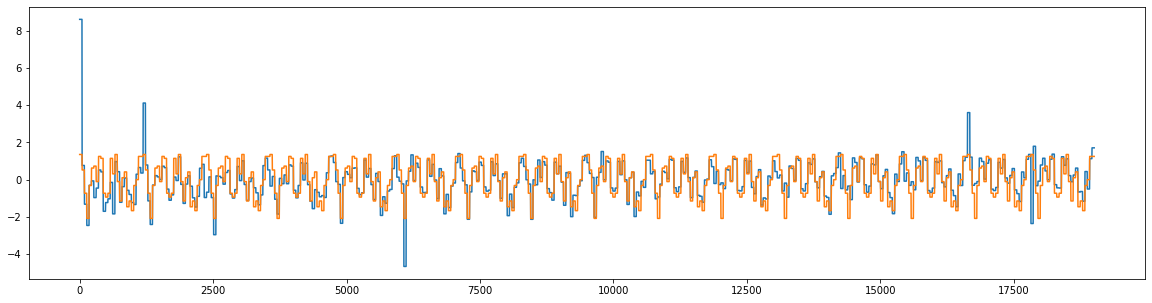

<Figure size 432x288 with 0 Axes>

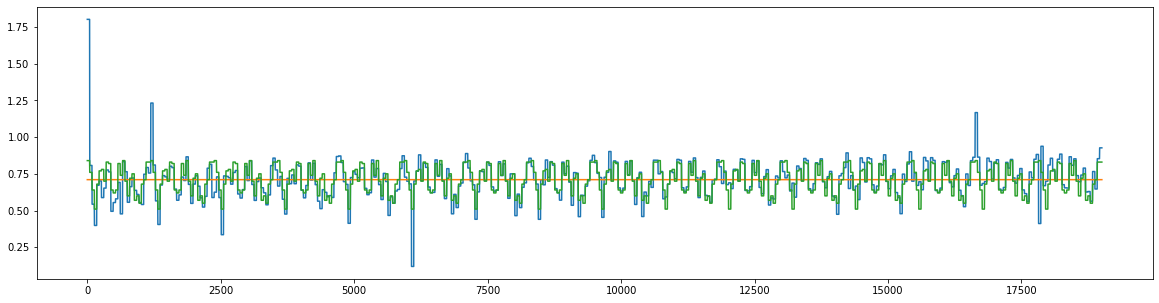

<class 'pandas.core.series.Series'> <class 'pandas.core.series.Series'> <class 'numpy.int64'>


/hy-tmp/yieldos/A0AM.py:267: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data_infer[f'{self.scrop}_sownarea'] = 0.0    #np.nan
/hy-tmp/yieldos/A0AM.py:268: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data_infer[f'{self.scrop}_yieldval'] = 0.0    #np.nan
/hy-tmp/yieldos/A0AM.py:269: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/

Years to train: ['2003', '2004', '2006', '2007', '2008', '2009', '2011', '2012', '2013', '2014', '2015', '2016', '2018']
Years to valid: ['2005', '2010', '2017']
--------check 2008----------------------
Years to train: ['2003' '2004' '2006' '2007' '2009' '2011' '2012' '2013' '2014' '2015'
 '2016' '2018']
Years to valid: ['2005', '2010', '2017']
Years to valid: ['2005' '2010' '2017']
------------------------------


/hy-tmp/yieldos/A0AM.py:318: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self.data[f'{self.scrop}_yield'].loc[(self.data['county'] == county) & (self.data['year'] == year) & \
/hy-tmp/yieldos/A0AM.py:320: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self.data['gstage'].loc[(self.data['county'] == county) & (self.data['year'] == year) & \
/hy-tmp/yieldos/A0AM.py:341: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self.data_val[f'{self

DATA_VAL: ['0' '1' '2'] (2754, 2812)
DATA_VAL: ['0' '1' '2'] (918, 2812)
DATA_VAL: ['0' '1' '2'] (34, 2812)
Augmentation for years list: [2003, 2004, 2006, 2007, 2009, 2011, 2012, 2013, 2014, 2015, 2016, 2018] by NSAMPLES=3 and YEARS_MAX_LENGTH=3


100%|██████████| 3/3 [00:15<00:00,  5.18s/it]


type(self.data_train[time_idx]) <class 'pandas.core.series.Series'>
time_idx [  0   1   2   3   4   5   6   7   8   9  10  11  12  13  14  15  16  17
  18  19  20  21  22  23  24  25  26  27  28  29  30  31  32  33  34  35
  36  37  38  39  40  41  42  43  44  45  46  47  48  49  50  51  52  53
  54  55  56  57  58  59  60  61  62  63  64  65  66  67  68  69  70  71
  72  73  74  75  76  77  78  79  80  81  82  83  84  85  86  87  88  89
  90  91  92  93  94  95  96  97  98  99 100 101 102 103 104 105 106 107
 108 109 110 111 112 113 114 115 116 117 118 119 120 121 122 123 124 125
 126 127 128 129 130 131 132 133 134 135 136 137 138 139 140 141 142 143
 144 145 146 147 148 149 150 151 152 153 154 155 156 157 158 159 160 161
 162 163 164 165 166 167 168 169 170 171 172 173 174 175 176 177 178 179
 180 181 182 183 184 185 186 187 188 189 190 191 192 193 194 195 196 197
 198 199 200 201 202 203 204 205 206 207 208 209 210 211 212 213 214 215
 216 217 218 219 220 221 222 223 224 225 226 22

/hy-tmp/yieldos/A0AM.py:484: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  dfali['time_idx'] = dflast['time_idx'].values


<Figure size 432x288 with 0 Axes>

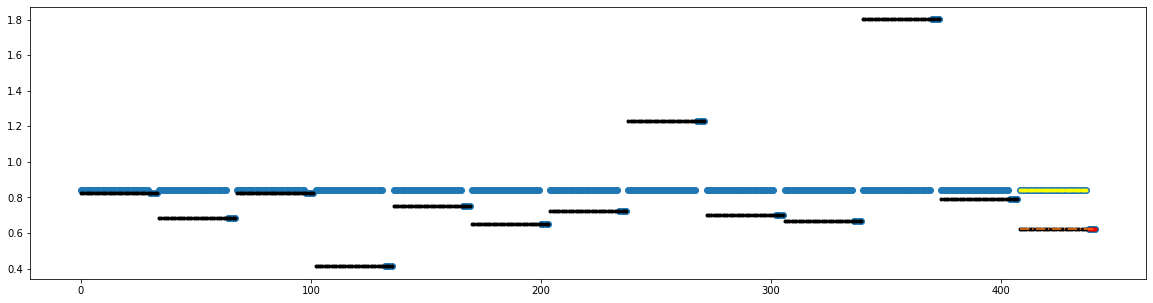

Dataframe size: 768.09 Mb
DataGenerator done...
Set basic filenames self.name_for_files: EXP_[A0AM_vis]-Cr[rice]-KF[2005_2010_2017]-BS[16]]
avg_med: ['avg_rice_yield', 'actuals']
training mx_epochs, TimeSeriesDataSet: 100 Tue Apr 11 20:53:47 2023
D1: known-unknown go --------------------------
D2: --------------------------
Tue Apr 11 20:53:53 2023
training & validation TimeSeriesDataSet loaded Tue Apr 11 20:53:56 2023
self.train_dataloader: 2050
self.val_dataloader: 3
self.test_dataloader: 3
Tue Apr 11 20:53:56 2023


/usr/local/lib/python3.8/dist-packages/pytorch_lightning/utilities/parsing.py:262: UserWarning: Attribute 'loss' is an instance of `nn.Module` and is already saved during checkpointing. It is recommended to ignore them using `self.save_hyperparameters(ignore=['loss'])`.
  rank_zero_warn(
/usr/local/lib/python3.8/dist-packages/pytorch_lightning/utilities/parsing.py:262: UserWarning: Attribute 'logging_metrics' is an instance of `nn.Module` and is already saved during checkpointing. It is recommended to ignore them using `self.save_hyperparameters(ignore=['logging_metrics'])`.
  rank_zero_warn(
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs


Baseline: tensor(0.0226)
Baseline: Tue Apr 11 20:53:57 2023
test
weights loading from checkpoint: EXP_[ZA0AM_CONV]-Cr[rice]-KF[2005_2010_2017]-BS[128]] Tue Apr 11 20:53:57 2023
weights loaded Tue Apr 11 20:53:58 2023
MAPE: {tensor(0.2772)}
SMAPE: {tensor(0.2770)}
A0MTEST_EXP_[A0AM_vis]-Cr[rice]-KF[2005_2010_2017]-BS[16]].png saved...


/usr/local/lib/python3.8/dist-packages/pytorch_forecasting/models/base_model.py:797: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  fig, ax = plt.subplots()


dict_keys(['prediction', 'encoder_attention', 'decoder_attention', 'static_variables', 'encoder_variables', 'decoder_variables', 'decoder_lengths', 'encoder_lengths', 'encoder_cat', 'encoder_cont', 'encoder_target', 'decoder_cat', 'decoder_cont', 'decoder_target', 'decoder_time_idx', 'groups', 'target_scale'])
(81, 8, 1)
torch.Size([81, 26])
torch.Size([81, 8])
test saved
The end...


SystemExit: 0

/usr/local/lib/python3.8/dist-packages/IPython/core/interactiveshell.py:3406: UserWarning: To exit: use 'exit', 'quit', or Ctrl-D.
  warn("To exit: use 'exit', 'quit', or Ctrl-D.", stacklevel=1)


<Figure size 432x288 with 0 Axes>

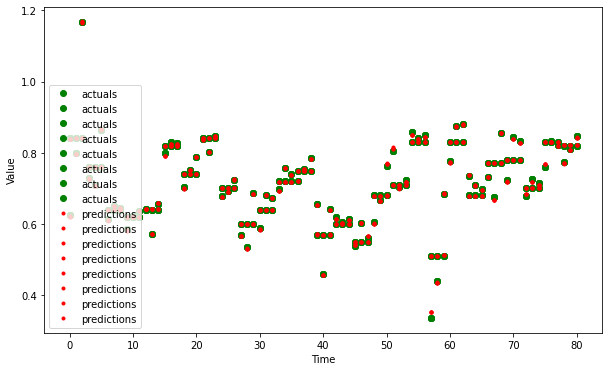

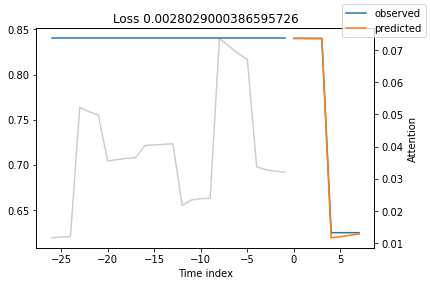

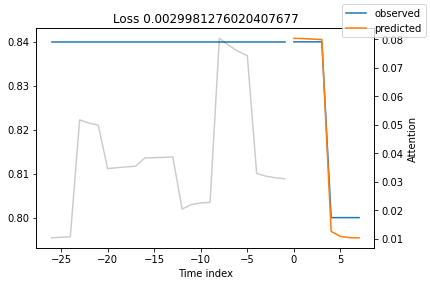

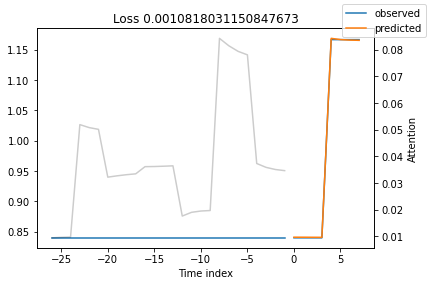

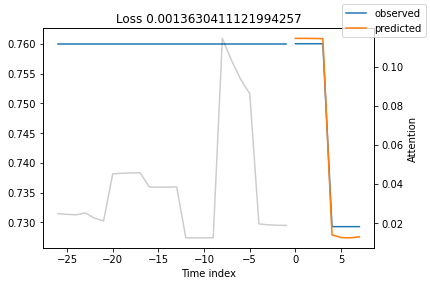

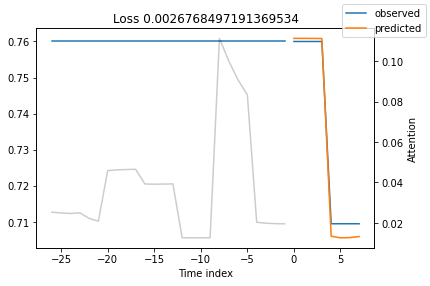

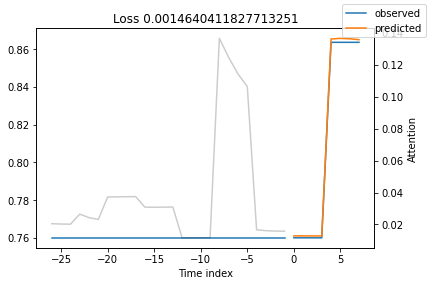

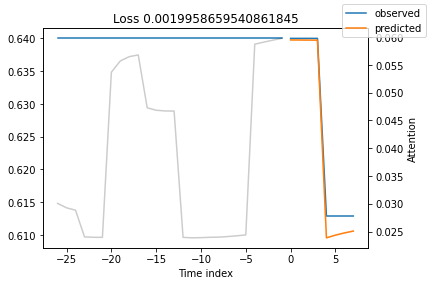

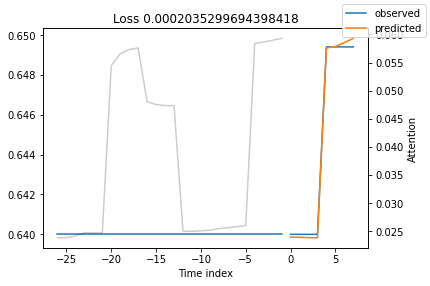

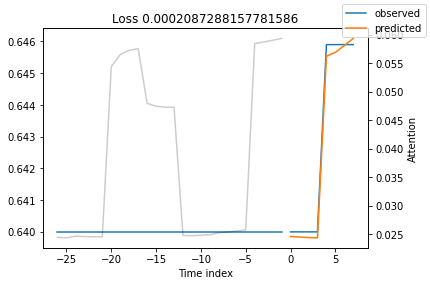

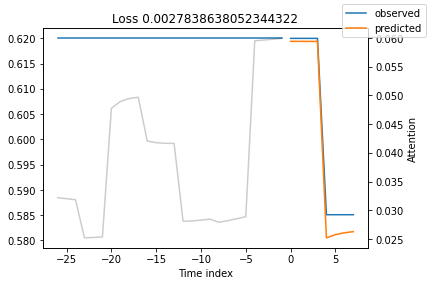

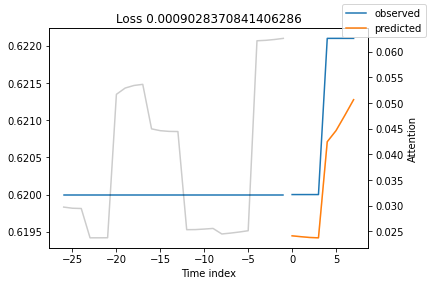

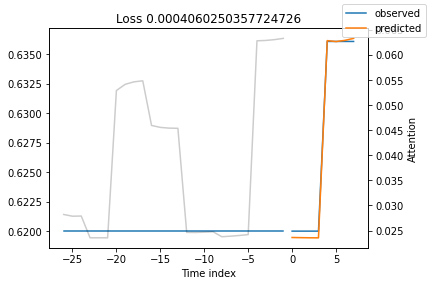

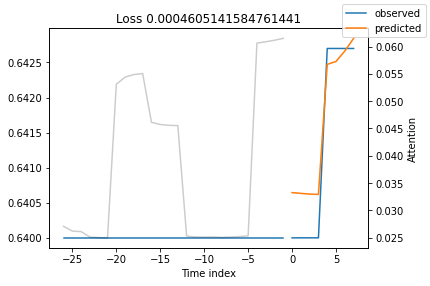

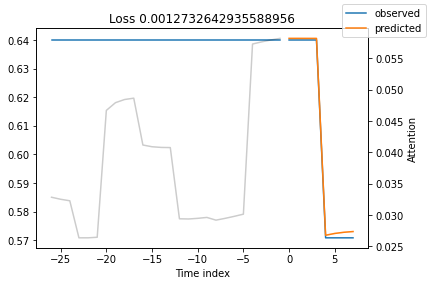

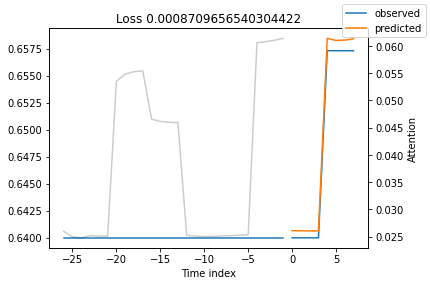

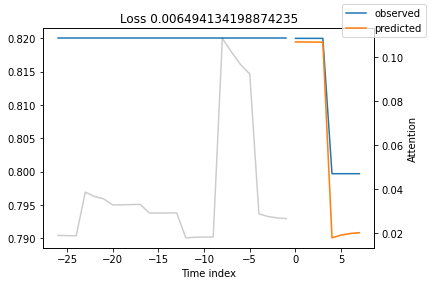

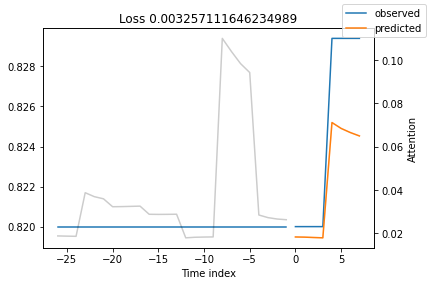

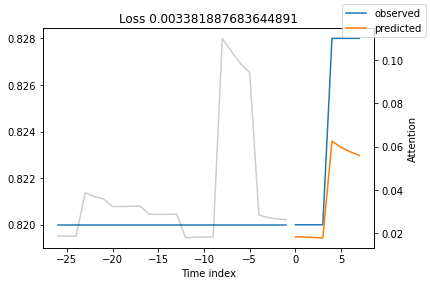

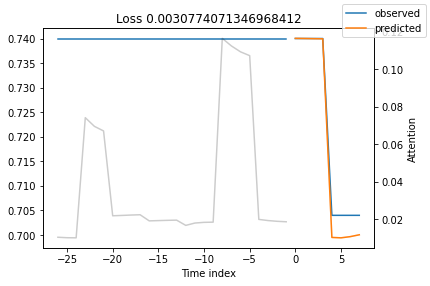

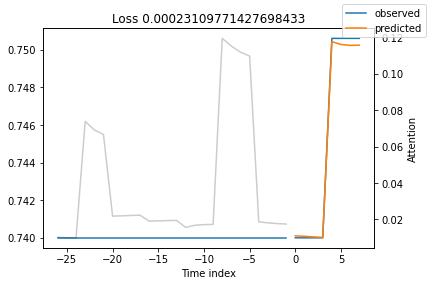

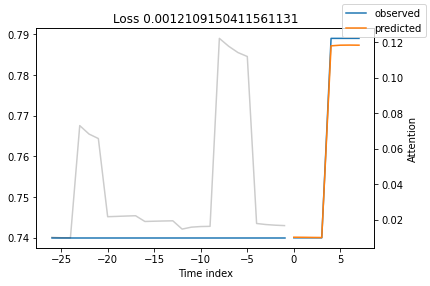

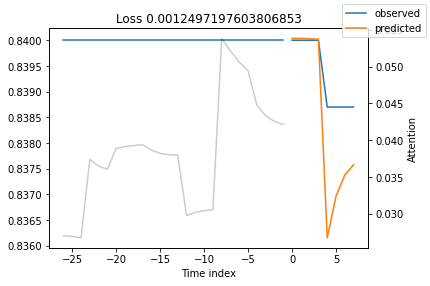

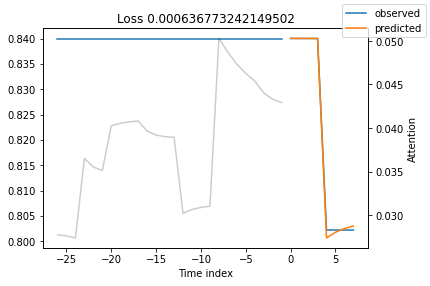

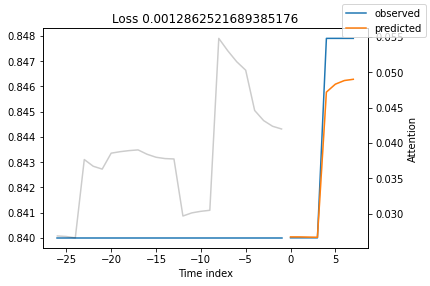

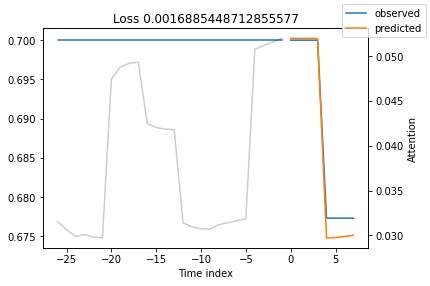

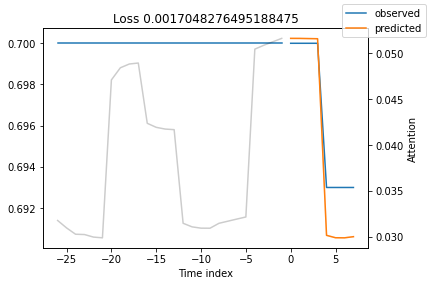

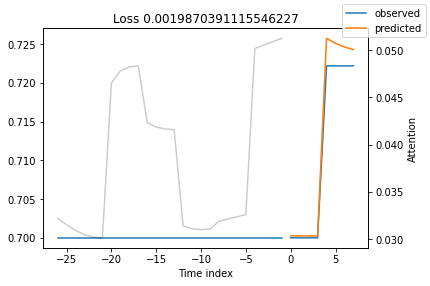

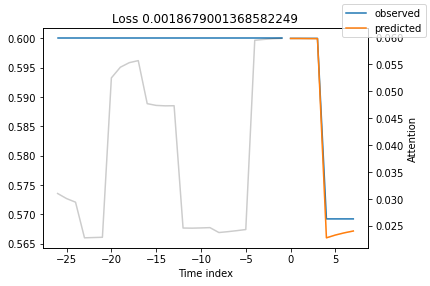

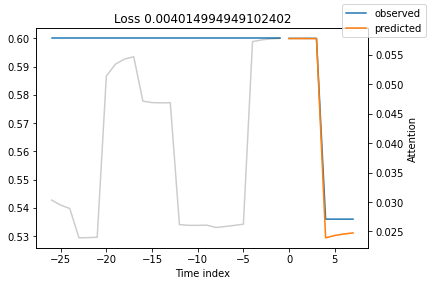

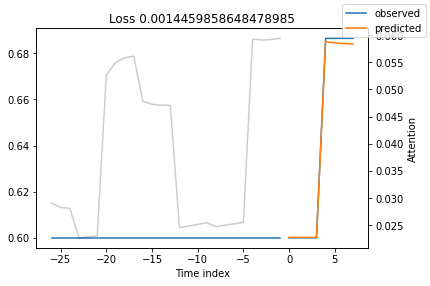

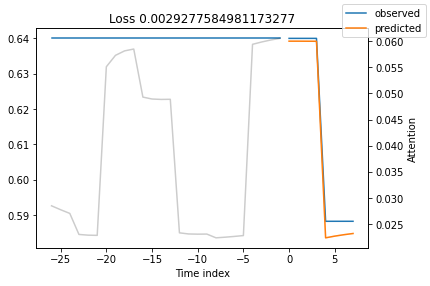

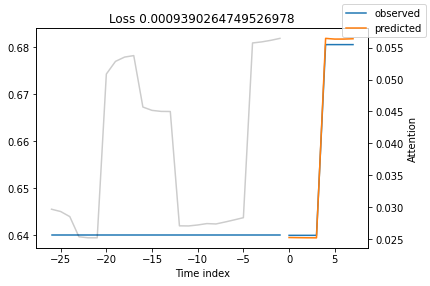

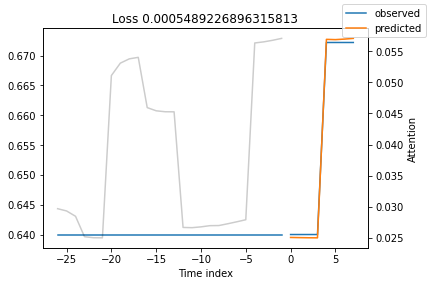

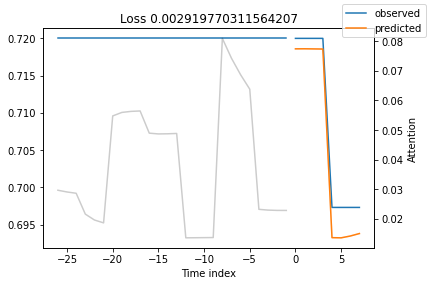

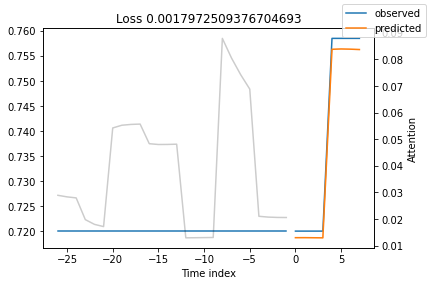

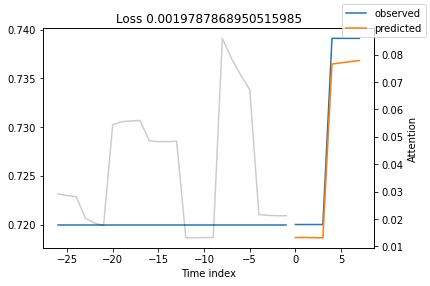

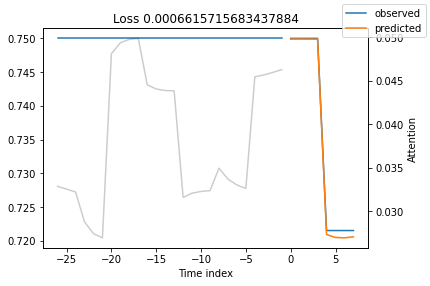

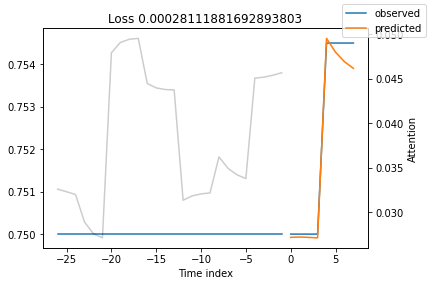

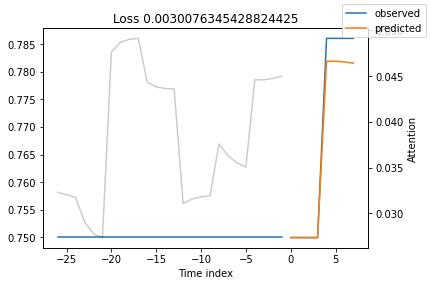

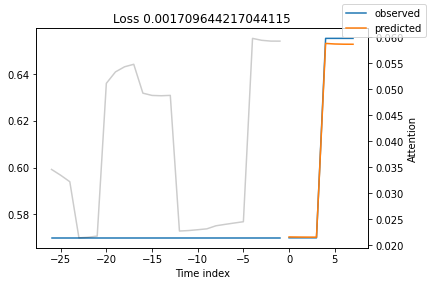

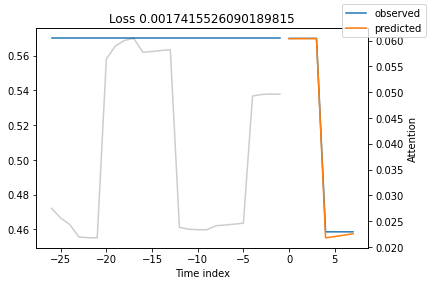

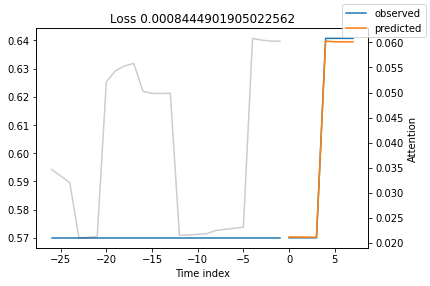

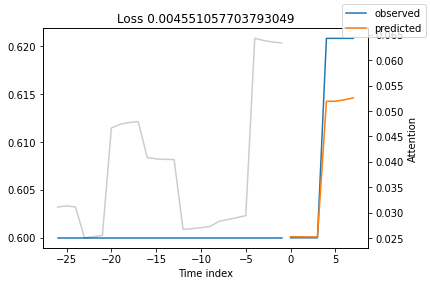

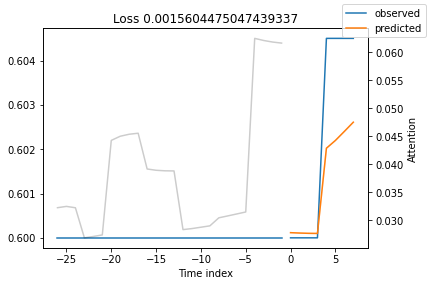

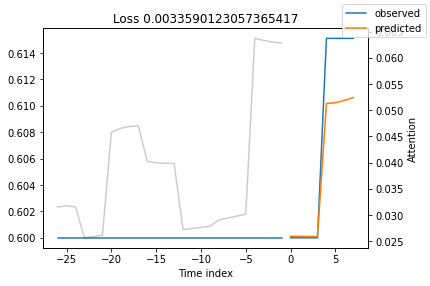

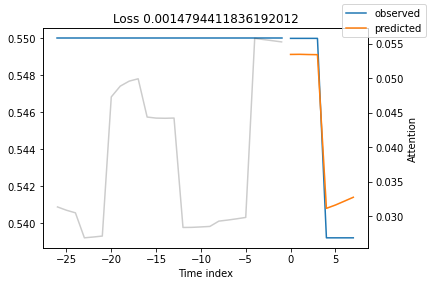

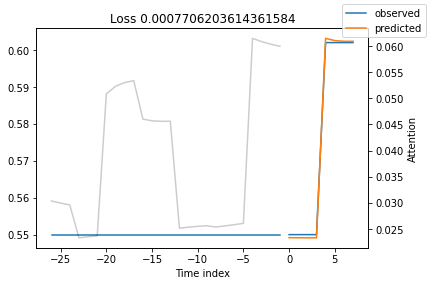

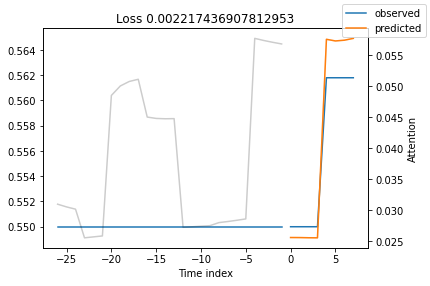

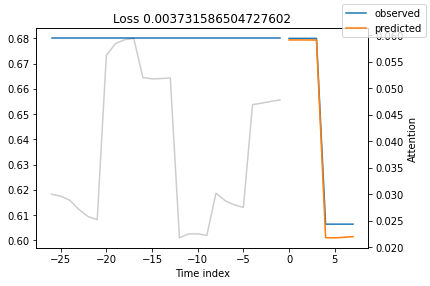

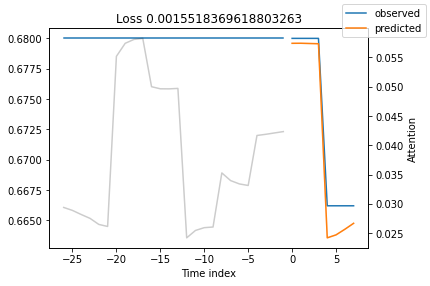

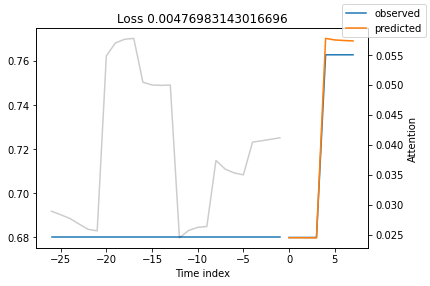

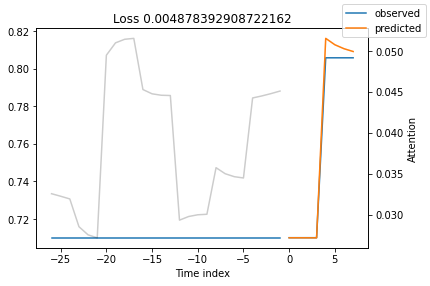

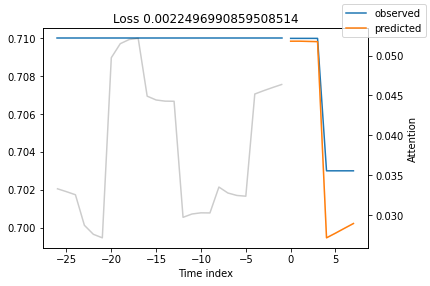

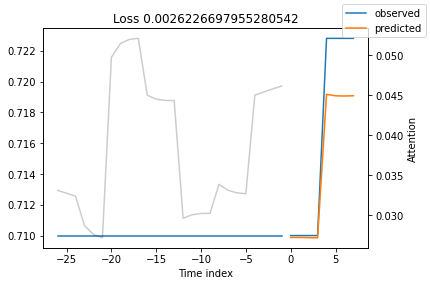

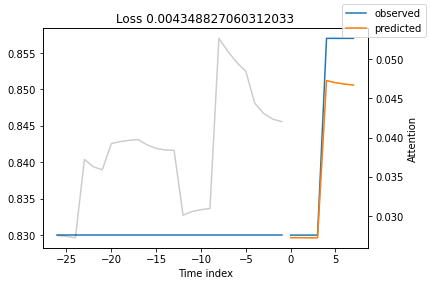

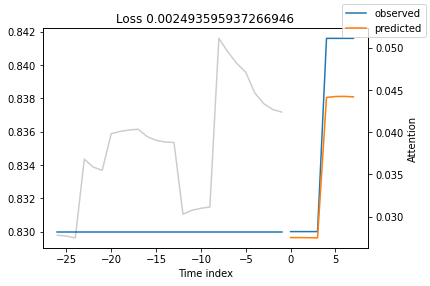

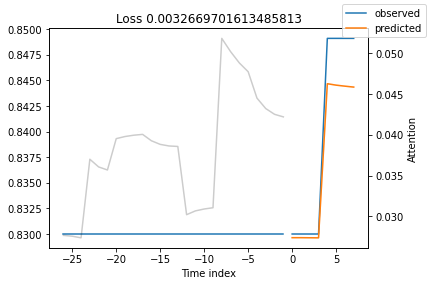

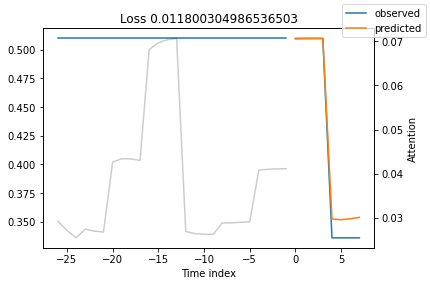

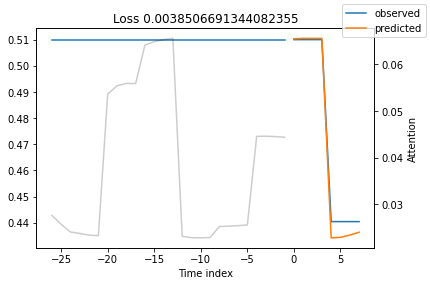

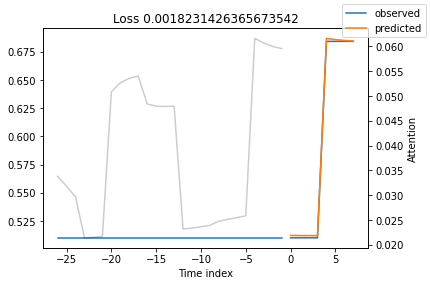

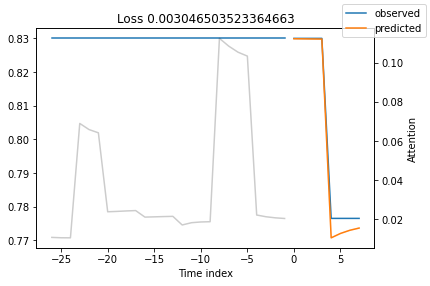

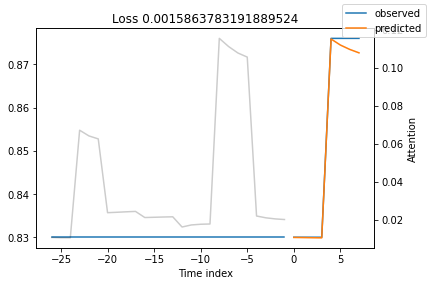

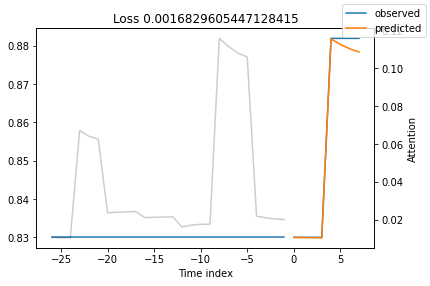

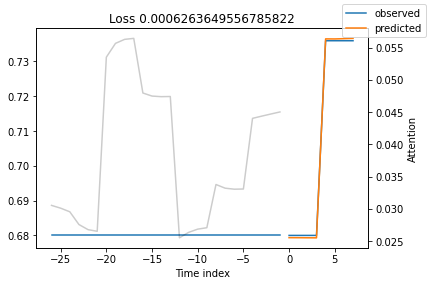

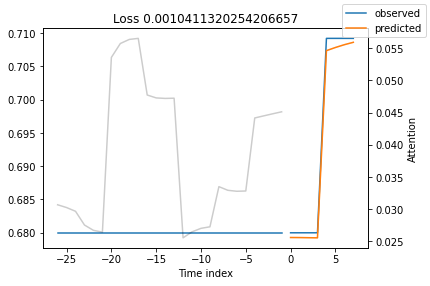

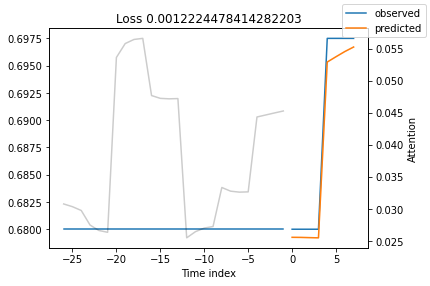

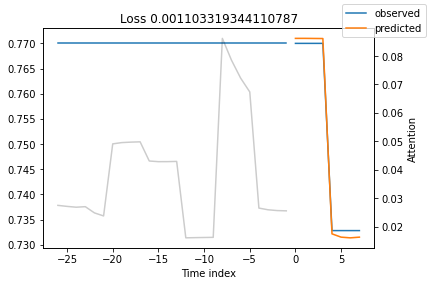

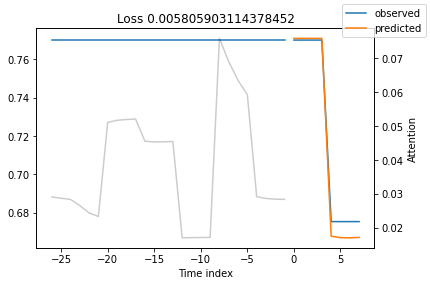

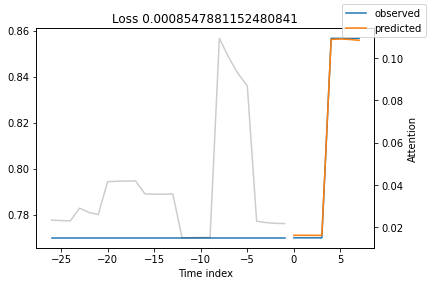

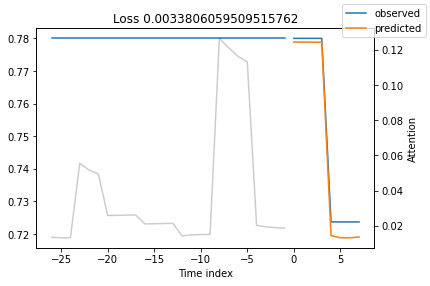

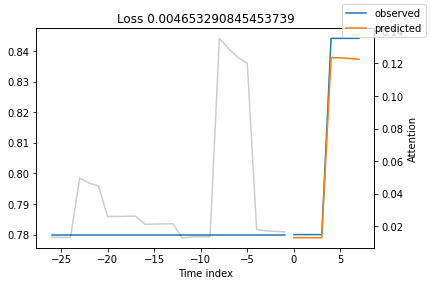

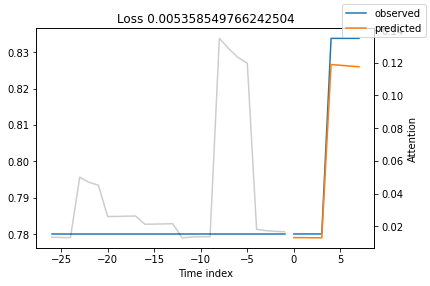

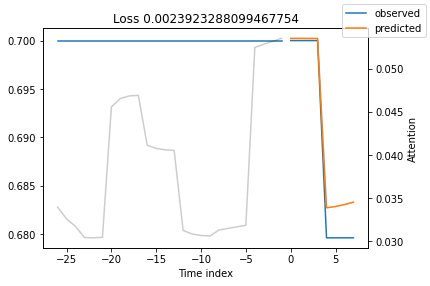

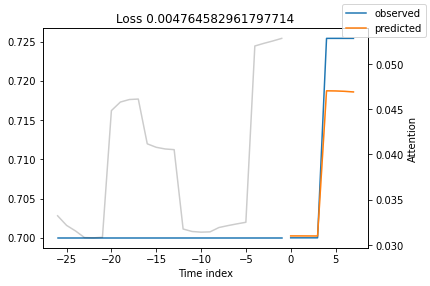

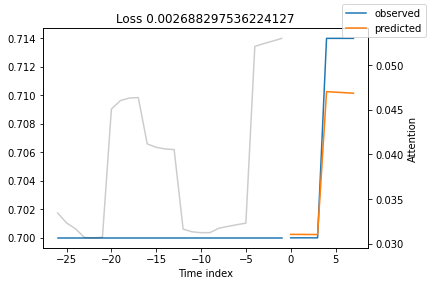

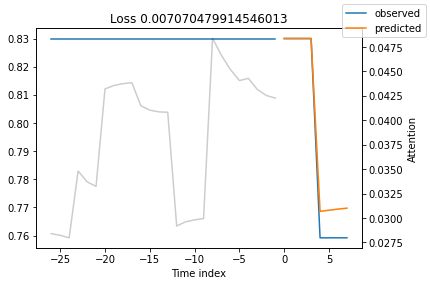

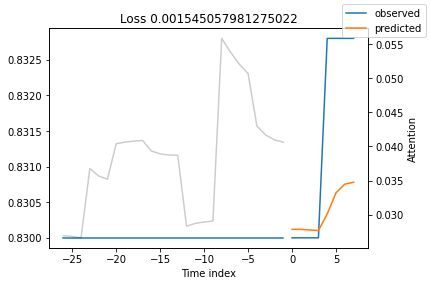

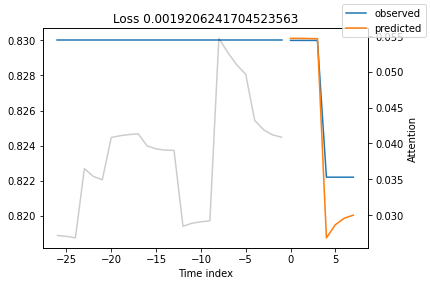

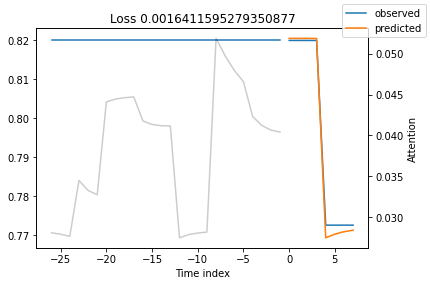

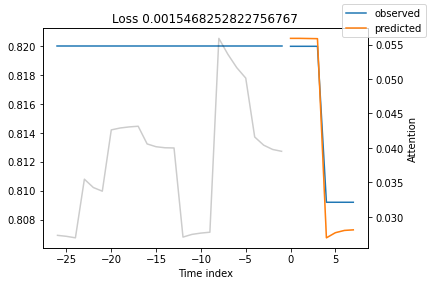

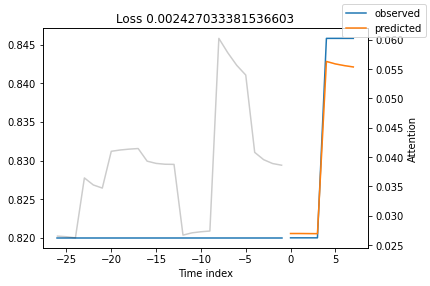

In [4]:
from A0AM import ModelBase

def train_TFT(exp_name, 
              crop_name='rice', 
              predicted_years="2005 2010 2017",
              batch_size=16,
              learning_rate=0.0325,
              loss_func_metric='RMSE', 
              max_epochs=100,
              checkpoit_file=checkpoint_file):

    # print('predicted year:', predicted_years, type(predicted_years))

    # torch.set_float32_matmul_precision('medium')

    log_file = os.path.join('/hy-tmp', f'Log-cr[{crop_name}]-yr[{predicted_years}]-en[{exp_name}]-bs[{batch_size}].log')

#         if os.path.exists(log_file):
#             print(f'log file {log_file} exist')
#             sys.exit(0)

#         sys.stdout = Logger(log_file)

    model = ModelBase(exp_name=exp_name, 
                      predicted_years=predicted_years,
                      max_epochs=max_epochs, 
                      batch_size=batch_size, 
                      learning_rate=learning_rate,
                      loss_func_metric=loss_func_metric)

    # model.init_lr_finder()
    # model.custom_finder()
    # model.train()
    # model.predict()
    model.test(checkpoit_file=checkpoint_file)
    # model.inference()
    # model.plot_predict()
    print('The end...')
    sys.exit(0)
    
train_TFT(exp_name='A0AM_vis', checkpoit_file=checkpoint_file)

In [ ]:
fn
print(data['prediction'].shape, data['encoder_target'].shape, data['decoder_target'].shape)
print( np.asarray(data['prediction'][0,0,0]) )
print( np.asarray(data['prediction'][0]) )

In [ ]:
MOD_BINS = 128
FAM_BINS = 64
datasetfile = f'data/ALIM{MOD_BINS}F{FAM_BINS}DATASET_rice.csv'
alidata = pd.read_csv(os.path.join(home_dir,datasetfile))

alidata.head()

In [ ]:
samples = [X for X in range(data['prediction'].shape[0])]

X = [X for X in range(0,5)]

# X = [X for X in range(data['encoder_target'][0:10])]

print(X)

X.append(len(X))

print(X)

files = [1,]

# fig, ax = plt.subplots(nrows=1, ncols=1, figsize=(20,5)) 
for sample in samples:
    # data = np.load(ifile)

    fig, ax = plt.subplots(nrows=1, ncols=1, figsize=(20,5)) 
    
    Y = np.array([])
    Y_= np.array([])
    
    Y = np.concatenate( (Y, np.asarray(data['encoder_target'][sample][...])) )
    Y_= np.concatenate( (Y_, np.asarray(data['encoder_target'][sample][...])) )
    
    # print(Y.shape)
    # fn

    # Y = np.asarray(data['decoder_target'][sample][...]) 
    # Y_ = np.asarray(data['prediction'][sample,...,0]) 
    
    Y = np.concatenate( (Y, np.asarray(data['decoder_target'][sample][...])) ) 
    Y_ = np.concatenate((Y_, np.asarray(data['prediction'][sample,...,0])) ) 
    
    # print(county, Y)
    # print(Y_)
    X = [X for X in range(len(Y))]
    ax.plot(np.asarray(X), np.asarray(Y), 'o', color='green')
    ax.plot(np.asarray(X), np.asarray(Y_), '.', color='red')
    ax.set(title=sample)
plt.ylim([0, 1.3])
plt.show()

# for ifile in files:
#     # data = np.load(ifile)
    
#     fig, ax = plt.subplots(nrows=1, ncols=1, figsize=(20,5)) 
#     for county in counties:
#         Y = np.asarray(data['decoder_target'][county][0]) 
#         Y_ = np.asarray(data['prediction'][county,0,0]) 
#         # print(county, Y)
#         # print(Y_)
#         ax.plot(np.asarray(county), np.asarray(Y), 'o', color='green')
#         ax.plot(np.asarray(county), np.asarray(Y_), '.', color='red')
#         ax.set(title=ifile)
#     plt.ylim([0, 1.3])
#     plt.show()

In [ ]:
fn